# Exercise 4: Supervised Learning
Source: https://github.com/jcrouser/islr-python/

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [14]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

# mpath='' # local files
mpath = "/content/gdrive/My Drive/Colab Notebooks/Data Science Class/Exercise/"
spath = "/content/gdrive/My Drive/Colab Notebooks/" # path to save your image files

Mounted at /content/gdrive


## 1. Forward Stepwise Selection
Here we apply the forward stepwise selection approach to the white wine quality data.
We wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [15]:
# Read data
ww_df = pd.read_csv(mpath+'data/winequality-white.csv', sep=';')
ww_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [16]:
# define the target variable
ww_y = ww_df['quality']
# define the set of possible predictors, all columns apart from the target variable
ww_X = ww_df.drop(['quality'], axis=1)

In [17]:
def processSubset(X, y, feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [18]:
def forward(X, y, predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X, y, predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a ${\tt DataFrame}$ containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [19]:
models = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1, len(ww_X.columns)+1):    
    models.loc[i] = forward(ww_X, ww_y, predictors) # search for best predictor at step i
    predictors = models.loc[i]["model"].model.exog_names # use the best predictor added at step i to start the search at step i+1

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 0.6005966663360596 seconds.


Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select.

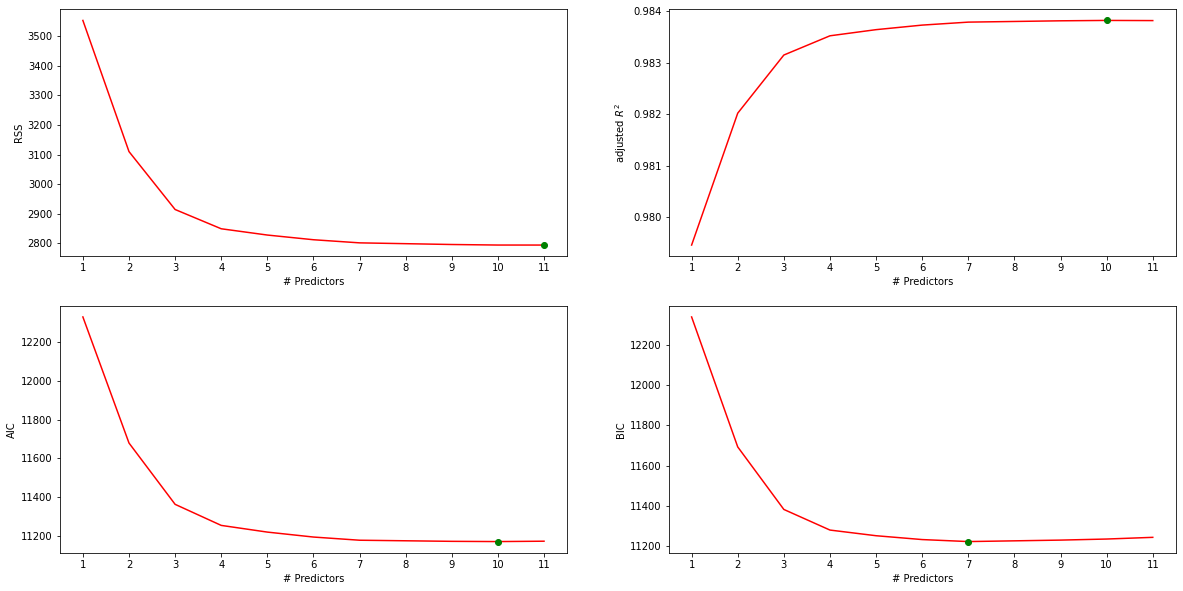

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))
ax = axes.flatten()

# We will now plot a red dot to indicate the model with the smallest RSS statistic.
# The idxmin() function can be used to identify the location of the minimum point of a vector
rss = models.apply(lambda row: row['RSS'], axis=1)
ax[0].plot(models['RSS'], color='red')
ax[0].plot(rss.idxmin(), rss.min(), 'og') # 'or' is a short hand for marker='o', color='r'
ax[0].set_xlabel('# Predictors')
ax[0].set_ylabel('RSS')
ax[0].set_xticks(np.arange(1, len(models)+1))

# Plot a red dot to indicate the model with the largest adjusted R^2 statistic.
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)
ax[1].plot(rsquared_adj, color='red')
ax[1].plot(rsquared_adj.idxmax(), rsquared_adj.max(), 'og')
ax[1].set_xlabel('# Predictors')
ax[1].set_ylabel('adjusted $R^2$')
ax[1].set_xticks(np.arange(1, len(models)+1))

# Do the same for AIC and BIC. For both metrics, the smaller the better
aic = models.apply(lambda row: row[1].aic, axis=1)
ax[2].plot(aic, color='red')
ax[2].plot(aic.idxmin(), aic.min(), 'og')
ax[2].set_xlabel('# Predictors')
ax[2].set_ylabel('AIC')
ax[2].set_xticks(np.arange(1, len(models)+1))

bic = models.apply(lambda row: row[1].bic, axis=1)
ax[3].plot(bic, color='red')
ax[3].plot(bic.idxmin(), bic.min(), 'og')
ax[3].set_xlabel('# Predictors')
ax[3].set_ylabel('BIC');
ax[3].set_xticks(np.arange(1, len(models)+1));

AIC and adjusted $R^2$ suggested a model with 10 predictors, while BIC suggested one with 7 predictors. Let's see what would a backward stepwise selection approach will suggest.
## 2. Backward Stepwise Selection
Not much has to change from the forward selection implementation to implement backward selection, just looping through the predictors in reverse.

In [21]:
def backward(X, y, predictors):
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(X, y, combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [22]:
models2 = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(ww_X.columns)))

tic = time.time()
predictors = ww_X.columns

models2.loc[len(predictors)] = processSubset(ww_X, ww_y, predictors) # add the model with all predictors

while(len(predictors) > 1): # loop until no predictors remain
    models2.loc[len(predictors)-1] = backward(ww_X, ww_y, predictors) # best model with k predictors
    predictors = models2.loc[len(predictors)-1]["model"].model.exog_names # best k predictors as input for the next model search, i.e. model with k-1 predictors

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 0.6010818481445312 seconds.


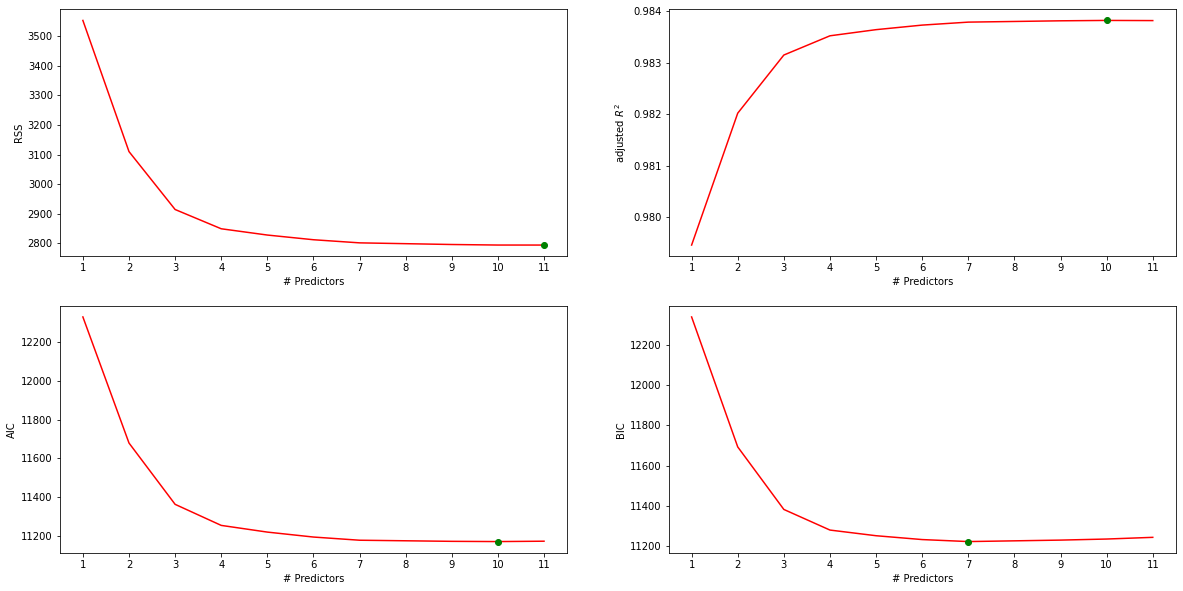

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))
ax = axes.flatten()

# We will now plot a red dot to indicate the model with the smallest RSS statistic.
# The idxmin() function can be used to identify the location of the minimum point of a vector
rss = models2.apply(lambda row: row['RSS'], axis=1)
ax[0].plot(models2['RSS'], color='red')
ax[0].plot(rss.idxmin(), rss.min(), 'og') # 'or' is a short hand for marker='o', color='r'
ax[0].set_xlabel('# Predictors')
ax[0].set_ylabel('RSS')
ax[0].set_xticks(np.arange(1, len(models)+1))

# Plot a red dot to indicate the model with the largest adjusted R^2 statistic.
rsquared_adj = models2.apply(lambda row: row[1].rsquared_adj, axis=1)
ax[1].plot(rsquared_adj, color='red')
ax[1].plot(rsquared_adj.idxmax(), rsquared_adj.max(), 'og')
ax[1].set_xlabel('# Predictors')
ax[1].set_ylabel('adjusted $R^2$')
ax[1].set_xticks(np.arange(1, len(models)+1))

# Do the same for AIC and BIC. For both metrics, the smaller the better
aic = models2.apply(lambda row: row[1].aic, axis=1)
ax[2].plot(aic, color='red')
ax[2].plot(aic.idxmin(), aic.min(), 'og')
ax[2].set_xlabel('# Predictors')
ax[2].set_ylabel('AIC')
ax[2].set_xticks(np.arange(1, len(models)+1))

bic = models2.apply(lambda row: row[1].bic, axis=1)
ax[3].plot(bic, color='red')
ax[3].plot(bic.idxmin(), bic.min(), 'og')
ax[3].set_xlabel('# Predictors')
ax[3].set_ylabel('BIC');
ax[3].set_xticks(np.arange(1, len(models)+1));

The backward stepwise selection seems to suggest similar, if not the same, models as the forward stepsie selection approach. Let's evaluate the set of predictors for models with 7 and 10 predictors generated from forward, backward and best subset selection approaches
## 3. Best Subset Selection

In [24]:
def getBest(X, y, k):
    
    results = []
    
    for combo in itertools.combinations(X.columns, k): # loop through the possible set combinations of k predictors
        results.append(processSubset(X, y, combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

In [25]:
models3 = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in [7, 10]: # only models with 7 and 10 predictors are evaluated
    models3.loc[i] = getBest(ww_X, ww_y, i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 3.2492713928222656 seconds.


In [26]:
for i in [7, 10]:
    print('Models with {} predictors:'.format(i))
    # use numpy.sort() to sort the predictor names
    print('Forward:\n predictors: {}, adjusted-R\u00b2: {:4.3f}'.format(np.sort(models.loc[i, "model"].model.exog_names), models.loc[i, "model"].rsquared_adj))
    print('Backward:\n predictors: {}, adjusted-R\u00b2: {:4.3f}'.format(np.sort(models2.loc[i, "model"].model.exog_names), models2.loc[i, "model"].rsquared_adj))
    print('Best Subset:\n predictors: {}, adjusted-R\u00b2: {:4.3f}'.format(np.sort(models3.loc[i, "model"].model.exog_names), models3.loc[i, "model"].rsquared_adj))
    print('')

Models with 7 predictors:
Forward:
 predictors: ['alcohol' 'density' 'fixed acidity' 'free sulfur dioxide'
 'residual sugar' 'sulphates' 'volatile acidity'], adjusted-R²: 0.984
Backward:
 predictors: ['alcohol' 'density' 'fixed acidity' 'free sulfur dioxide'
 'residual sugar' 'sulphates' 'volatile acidity'], adjusted-R²: 0.984
Best Subset:
 predictors: ['alcohol' 'density' 'fixed acidity' 'free sulfur dioxide'
 'residual sugar' 'sulphates' 'volatile acidity'], adjusted-R²: 0.984

Models with 10 predictors:
Forward:
 predictors: ['alcohol' 'chlorides' 'density' 'fixed acidity' 'free sulfur dioxide'
 'pH' 'residual sugar' 'sulphates' 'total sulfur dioxide'
 'volatile acidity'], adjusted-R²: 0.984
Backward:
 predictors: ['alcohol' 'chlorides' 'density' 'fixed acidity' 'free sulfur dioxide'
 'pH' 'residual sugar' 'sulphates' 'total sulfur dioxide'
 'volatile acidity'], adjusted-R²: 0.984
Best Subset:
 predictors: ['alcohol' 'chlorides' 'density' 'fixed acidity' 'free sulfur dioxide'
 'pH' 

In this dataset all three approaches yielded identical sets of predictors on models with 7 and 10 predictors
## 4. Model Selection Using Cross-Validation
Here we perform cross validation on the backward stepwise selection approach.

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=10, shuffle=True, random_state=0)
models_cv = pd.DataFrame(columns=["RSS", "model"])
cv_rmse, models4 = [], []

for train_idx, test_idx in kf.split(ww_X):
    
    predictors, fold_rmse = ww_X.columns, [] # Reset predictors and metric containers for each fold

    # add the model with all predictors
    models_cv.loc[len(predictors)] = processSubset(ww_X, ww_y, predictors)['model']
    model = models_cv.loc[len(predictors)].model
    y_train_pred = model.predict(ww_X.iloc[train_idx][list(predictors)])        
    fold_rmse.append(np.sqrt(mean_squared_error(ww_y[train_idx], y_train_pred)))

    # Inner loop iterates over each size i
    while(len(predictors) > 1): # loop until no predictors remain
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[len(predictors)-1] = backward(ww_X, ww_y, predictors) # best model with k predictors
        model = models_cv.loc[len(predictors)-1].model

        # Extract the predictors
        predictors = models_cv.loc[len(predictors)-1]["model"].model.exog_names # best k predictors as input for the next model search, i.e. model with k-1 predictors
        
        # Save the cross-validated test error for this fold
        y_test_pred = model.predict(ww_X.iloc[test_idx][list(predictors)])        
        fold_rmse.append(np.sqrt(mean_squared_error(ww_y[test_idx], y_test_pred)))

    cv_rmse.append(fold_rmse)
    models4.append(models_cv)

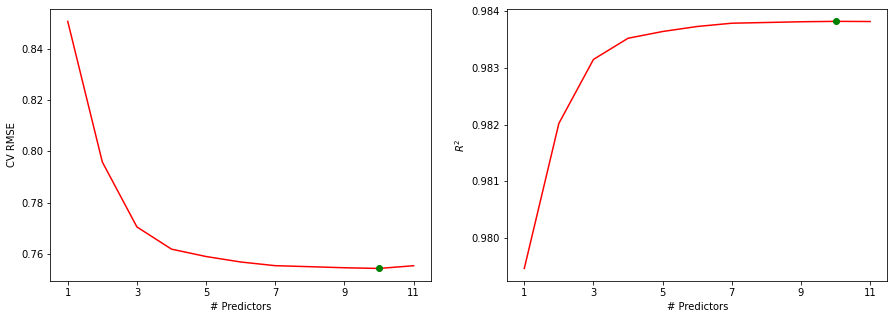

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
ax = axes.flatten()

x = np.arange(1, len(models_cv)+1)

cv_rmse_mean = np.mean(cv_rmse, axis=0)[::-1] # get the mean error for each number of predictor, [::-1] is to reverse the list order
ax[0].plot(x, cv_rmse_mean, color='red')
ax[0].set_xlabel('# Predictors')
ax[0].set_ylabel('CV RMSE')
ax[0].plot(cv_rmse_mean.argmin()+1, cv_rmse_mean.min(), "og")
ax[0].set_xticks(np.arange(1, len(models_cv)+1, 2))

rsquared_adj = np.mean([[n.rsquared_adj for n in m['model']] for m in models4], axis=0)[::-1]
# given l is a list of lists: [[1,2,3], [3,2,5], [6,4,7]]
# the a nested list comprehension: [[x*2 for x in y] for y in l] is equivalent to the following nested for loops:
# res, temp = [], []
# for y in l:
#    for x in y:
#        temp.append(x*2)
#    res.append(temp)
# res: [[2, 4, 6], [6, 4, 10], [12, 8, 14]]
# this allows us to access each models, and returns a selected model statistic in a format like our cv_rmse without explicitly collecting the values

ax[1].plot(x, rsquared_adj, color='red')
ax[1].plot(np.argmax(rsquared_adj)+1, np.max(rsquared_adj), 'og')
ax[1].set_xlabel('# Predictors')
ax[1].set_ylabel('$R^2$')
ax[1].set_xticks(np.arange(1, len(models_cv)+1, 2));

The 10-fold cross validation approach suggests the model with 10 predictors. This can help us to choose this model over the one with 7 predictors.
## 5. Lasso Regression
Let's revisit the Hitters dataset. In 'Exercise_04_Demo.ipynb', we saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the ${\tt Lasso()}$ function; however, this time we'll need to include the argument ${\tt max}$_${\tt iter=10000}$.
Other than that change, we proceed just as we did in fitting a ridge model:

In [29]:
# data preprocessing as in 'Exercise_04_Demo.ipynb'
ht_df = pd.read_csv(mpath+'data/Hitters.csv')
# Drop any rows the contain missing values, along with the player names
ht_df = ht_df.dropna().drop('Player', axis=1).reset_index(drop=True)

dummies = pd.get_dummies(ht_df[['League', 'Division', 'NewLeague']])

# use log-transformed salary variable, see DM_04_Supervised_Learning__Evaluation_Bias-Variance.pdf
ht_y = ht_df['Salary'].apply(np.log)

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
ht_X = ht_df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# dataset of all dependent feature set
ht_X = pd.concat([ht_X, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

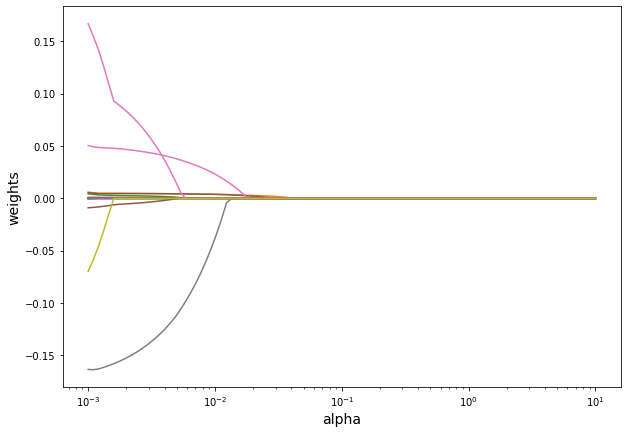

In [30]:
from sklearn.linear_model import Lasso, LassoCV

lasso = Lasso(max_iter=10000, normalize=True)
alphas = 10**np.linspace(1,-3,100)*0.5
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(ht_X, ht_y)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10, 7))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', size=14)
plt.ylabel('weights', size=14);

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ht_X, ht_y, test_size=0.5, train_size=0.5, random_state=0)
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
np.round(mean_squared_error(y_test, lasso.predict(X_test)), 3)

0.431

This is lower than the test set MSE of
least squares (0.491), and also better than the test MSE of ridge regression (0.453) with alpha
chosen by cross-validation.

Morevoer, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 11 of
the 19 coefficient estimates are exactly zero:

In [32]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=ht_X.columns)

AtBat          0.000000
Hits           0.000645
HmRun          0.000000
Runs           0.000229
RBI            0.005922
Walks          0.001857
Years          0.000000
CAtBat         0.000000
CHits          0.000568
CHmRun         0.000000
CRuns          0.000320
CRBI           0.000000
CWalks         0.000000
PutOuts        0.000000
Assists       -0.000000
Errors        -0.000933
League_N       0.000000
Division_W    -0.028562
NewLeague_N    0.000000
dtype: float64

As expected, some of the coefficients are exactly zero - lasso regression performs variable selection.

## 6. Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

We'll start by using **classification trees** to analyze the ${\tt Carseats}$ data set. In these
data, ${\tt Sales}$ is a continuous variable, and so we begin by converting it to a
binary variable. We use the ${\tt ifelse()}$ function to create a variable, called
${\tt High}$, which takes on a value of ${\tt Yes}$ if the ${\tt Sales}$ variable exceeds 8, and
takes on a value of ${\tt No}$ otherwise. We'll append this onto our dataFrame using the ${\tt .map()}$ function, and then do a little data cleaning to tidy things up:

In [34]:
car_df = pd.read_csv(mpath+'data/Carseats.csv')

car_df['High'] = car_df.Sales.map(lambda x: 1 if x>8 else 0)

car_df.ShelveLoc = pd.factorize(car_df.ShelveLoc)[0]
car_df.Urban = car_df.Urban.map({'No':0, 'Yes':1})
car_df.US = car_df.US.map({'No':0, 'Yes':1})

In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [35]:
X = car_df.drop(['Sales', 'High'], axis=1)
y = car_df.High

Do cross-validation to decide the depth of a tree using the ${\tt max\_depth}$ parameter:

In [36]:
from sklearn.model_selection import cross_val_score

# first we will set aside a true test set. This set is not included in the cross validation process
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)

# here we are using the cross_val_score function to get cross-validated score for each parameter setting, e.g. different max_depth
depth = []
for i in range(2,10):
    dt_clf = DecisionTreeClassifier(max_depth=i, random_state=0)
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator=dt_clf, X=X_train, y=y_train, cv=10, n_jobs=2, scoring='accuracy') # n_jobs is to indicate the number of CPUs to use
    depth.append((i, scores.mean()))

In [37]:
# get max_depth with maximum cross-validated score, in our case the one with the best accuracy
cv_depth_ = max(depth, key=lambda item:item[1])
print(cv_depth_)

(3, 0.728125)


In [38]:
from sklearn.metrics import classification_report

dt_cv = DecisionTreeClassifier(max_depth=cv_depth_[0], random_state=0)
dt_cv.fit(X_train, y_train)
print('Max depth: {}'.format(cv_depth_[0]))
print('Train accuracy: {:5.2f}%'.format(dt_cv.score(X_train, y_train)*100))
print('Test accuracy: {:5.2f}%\n'.format(dt_cv.score(X_test, y_test)*100))

y_pred = dt_cv.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
print('')
print(classification_report(y_test, y_pred))

Max depth: 3
Train accuracy: 77.81%
Test accuracy: 72.50%

     No  Yes
No   30    9
Yes  13   28

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        43
           1       0.68      0.76      0.72        37

    accuracy                           0.73        80
   macro avg       0.73      0.73      0.72        80
weighted avg       0.73      0.72      0.73        80



In [39]:
dt_8 = DecisionTreeClassifier(max_depth=8, random_state=0)
dt_8.fit(X_train, y_train)
print('Max depth: 8')
print('Train accuracy: {:5.2f}%'.format(dt_8.score(X_train, y_train)*100))
print('Test accuracy: {:5.2f}%\n'.format(dt_8.score(X_test, y_test)*100))

y_pred = dt_8.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
print('')
print(classification_report(y_test, y_pred))

Max depth: 8
Train accuracy: 98.44%
Test accuracy: 72.50%

     No  Yes
No   35   14
Yes   8   23

              precision    recall  f1-score   support

           0       0.71      0.81      0.76        43
           1       0.74      0.62      0.68        37

    accuracy                           0.73        80
   macro avg       0.73      0.72      0.72        80
weighted avg       0.73      0.72      0.72        80



Let's compare the decision tree with a maximum depth of 3, chosen via cross-validation, and the one with maximum depth of 8 we had in 'Exercise_04_Demo.ipynb'. Both gives out the same test accuracy, and the depth-3 tree is only marginally better on the f1-score. The depth-3 tree will be preferable as it has less complexity, and also by inspecting the training accuracy the depth-8 model indicates overfitting.